In [1]:
"""
Check all datasets
"""
%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')
from ipywidgets import interact
from ipywidgets import Controller

from collections import defaultdict
import numpy as np
import os
import sys
import itertools
from tqdm import tqdm
import pandas as pd
from pprint import pprint
import regex as re
sys.path.append('/export/home/asanakoy/workspace/neural_network')
sys.path.append('/export/home/asanakoy/workspace/art_datasets')
sys.path.append('/export/home/asanakoy/workspace/dataset_merger')
import make_data.dataset
import wikiart.info.preprocess_info
from art_utils.pandas_tools import is_null_object
from art_utils.text_tools import extract_all_years
import dataset_merger.read_datasets
import dataset_merger.pymongoext as pymongoext
from dataset_merger.match_artists import fix_sim_matrix
from dataset_merger.match_artists import generate_matches_for_manual_check
from dataset_merger.match_artists import get_num_top_matches
from dataset_merger.match_artists import compute_sim_matrix
from dataset_merger.match_artists import find_connected_components
from dataset_merger.match_artists import combine_artists
from dataset_merger.match_artists import get_merged_artists_df
import dataset_merger.prepare_artists as prepare_artists
from dataset_merger.prepare_artists import get_artists_with_years

pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 50)  
pd.set_option('display.max_columns', None) 

# todo: merge wga, wikiart, artuk, googleart (dates checked)
# todo: make uniform dates (bio or active if no bio available) range for every artist in the dataset

# todo: check dates on others
# todo: chach should we split naems on `&` for other datasets (beyound artuk, wikiart, googleart, wga)
# TOD: manually check connected components (wga, artuk)

In [2]:
dfs = dataset_merger.read_datasets.read_datasets()

artuk
artuk 207585
googleart
googleart 105963
moma
moma 25872
rijks
rijks 96189
wga
wga 35884
wiki
wiki 132296
meisterwerke
meisterwerke 19647
Total works count: 623436
time: 13.8 s


In [3]:
# for key, df in dfs.iteritems():
#     print key
#     print df.columns
#     print '==='
    

# print '--'
# artist_names = np.unique(artist_names)
# print 'Total unique artists num:', len(artist_names)
# return artist_names

time: 2.4 ms


In [4]:
artists_with_years_dict = dict()
artists_with_years_dict['googleart'] = get_artists_with_years('googleart', dfs)
artists_with_years_dict['wiki'] = get_artists_with_years('wiki', dfs)
artists_with_years_dict['wga'] = get_artists_with_years('wga', dfs)
# artists_with_years_dict['artuk'] = get_artists_with_years('artuk', dfs)
artists_with_years_dict['meisterwerke'] = get_artists_with_years('meisterwerke', dfs)

100%|██████████| 4445/4445 [00:00<00:00, 44386.12it/s]

with url_wiki: 3202
4445
4380



100%|██████████| 2276/2276 [00:00<00:00, 44534.91it/s]


2276
2270


100%|██████████| 4727/4727 [00:00<00:00, 50601.11it/s]


4727
4727


100%|██████████| 2294/2294 [00:00<00:00, 31792.67it/s]

2294
2182
Discarded 17 unknown artists
time: 3.24 s


In [5]:
# artcyclopedia_artists = pymongoext.get_db_entries('129.206.117.36', 27017, 'artcyclopedia', 'found')
# for x in artcyclopedia_artists:
#     x['artcylopedia_name'] = x['name']
#     del x['name']
#     del x['_id']
#     if 'content' in x:
#         del x['content']
# print len(artcyclopedia_artists)
# print artcyclopedia_artists[:2]

# artcyclopedia_df = pd.DataFrame.from_dict(artcyclopedia_artists)
# artcyclopedia_df.index = artcyclopedia_df['artist_name']
# artcyclopedia_df.rename(columns={'url': 'url_artcyclopedia'}, inplace=True)

# # artists_df['url_artcyclopedia'] = artcyclopedia_df.loc[artist_names, 'url_artcyclopedia'].values
# # print pd.notnull(artists_df['url_artcyclopedia']).sum()
# print len(artcyclopedia_df)
# print len(artcyclopedia_df['url_artcyclopedia'].unique())


# artcyclopedia_df

time: 3.51 ms


In [6]:
def get_sim_matrix(dataset_names, shape=None, force=False, n_jobs=1):
    assert len(dataset_names) == 2
    str_name = '-'.join(dataset_names)
    matrix_filepath = 'sim_matrix_{}.npy'.format(str_name)
    if os.path.exists(matrix_filepath) and not force:
        sim = np.load(matrix_filepath)
        if shape is not None:
            assert shape == sim.shape, '{} != {}'.format(shape, sim.shape)
    else:
        sim = compute_sim_matrix(keys, artists_with_years_dict, n_jobs=n_jobs)
        np.save(matrix_filepath, sim)
        print 'Sim matrix saved to {}'.format(matrix_filepath)
    return sim

def get_sim_matrix_and_plot(dataset_names, force=False, n_jobs=1):
    str_name = '-'.join(dataset_names)
    print str_name
    shape = tuple([len(artists_with_years_dict[dataset_names[i]]) for i in xrange(2)])
    sim_matrix[str_name] = get_sim_matrix(dataset_names, shape=shape, force=force, n_jobs=n_jobs)
    print sim_matrix[str_name].shape
    best_sim = sim_matrix[str_name].max(axis=1)
    plt.hist(best_sim)
    plt.show()

sim_matrix = dict()

time: 17.7 ms


In [7]:
def check_pairs(dataset_names, transpose=False, 
                min_sim=85, max_sim=100, 
                discard_exaclty_matched_dates=False,
                min_k=1, min_total_works_count=0):
    assert len(dataset_names) == 2
    sim = sim_matrix['-'.join(dataset_names)]
    dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

    manually_checked_matches_path = 'manually_corrected_matches/{}_manually_corrected_matches.csv'.format('-'.join(dataset_names))
    if os.path.exists(manually_checked_matches_path):
        manually_checked_matches_df = pd.read_csv(manually_checked_matches_path, index_col=0, encoding='utf-8')
        print 'manually checked pairs:', len(manually_checked_matches_df)
        sim = fix_sim_matrix(dataset_names, 
                             dfs_to_merge, 
                             sim, 
                             manually_checked_matches_df)
    
    if transpose:
        # Transpose matches
        dataset_names = dataset_names[::-1]
        dfs_to_merge = dfs_to_merge[::-1]
        sim = sim.transpose()

    results_df = generate_matches_for_manual_check(dataset_names, dfs_to_merge, 
                                                   sim, min_sim=min_sim, max_sim=max_sim,
                                                   discard_exaclty_matched_dates=discard_exaclty_matched_dates,
                                                   min_k=min_k, 
                                                   min_total_works_count=min_total_works_count)
    output_path = '/export/home/asanakoy/workspace/dataset_merger/aggregated/{}_check_matches.csv'.format('-'.join(dataset_names))
    results_df.to_csv(output_path, encoding='utf-8')
    return results_df

time: 16.1 ms


In [8]:
def correct_ids_in_manually_checked_matches(dataset_names):
    """
        Check each pair in manually_checked_matches and change $artist_id to one from 'artist_ids' list (if possible)
        if $artist_id is not currently in index of the artist_df
    """
    
    manually_checked_matches_path = 'manually_corrected_matches/{}_manually_corrected_matches.csv'.format('-'.join(dataset_names))
    if not os.path.exists(manually_checked_matches_path):
        raise IOError('File {} not found'.format(manually_checked_matches_path))
    manually_checked_matches_df = pd.read_csv(manually_checked_matches_path, index_col=0, encoding='utf-8')
    print 'manually checked pairs:', len(manually_checked_matches_df)

    dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]
    
    def convert_to_valid_idx(artists_df, artist_id):
        if artist_id not in artists_df.index:
            found_idxs = np.nonzero(artists_df['artist_ids'].apply(lambda x: artist_id in x))[0]
            if len(found_idxs):
                assert len(found_idxs) == 1, '{}: {}'.format(artist_id, found_idxs)
                artist_id = artists_df.index[found_idxs[0]]
        return artist_id
        
    
    def is_valid_pairs(row):
        for i in xrange(2):
            artist_id = row['artist_id_' + dataset_names[i]]
            if artist_id not in dfs_to_merge[i].index:
                return False
        return True
    
    is_valid = manually_checked_matches_df.apply(is_valid_pairs, axis=1)
    print 'not valid before fixes:', (~is_valid).sum()
    print manually_checked_matches_df[~is_valid]
    
    for i in xrange(2):
        manually_checked_matches_df['artist_id_' + dataset_names[i]] = \
            manually_checked_matches_df['artist_id_' + dataset_names[i]] \
            .apply(lambda x: convert_to_valid_idx(dfs_to_merge[i], x))
    
    is_valid = manually_checked_matches_df.apply(is_valid_pairs, axis=1)
    print 'not valid', (~is_valid).sum()
    print manually_checked_matches_df[~is_valid]
    return manually_checked_matches_df

# dataset_names = ['wiki+googleart', 'wga']
# dataset_names = ['wiki+googleart+wga', 'meisterwerke']
# manually_checked_matches_df = correct_ids_in_manually_checked_matches(dataset_names)
# manually_checked_matches_path = 'manually_corrected_matches/{}_manually_corrected_matches.csv'.format('-'.join(dataset_names))
# manually_checked_matches_df.to_csv(manually_checked_matches_path, encoding='utf-8')

time: 41.5 ms


In [9]:
# def fix_wga_ids(matches_df):
    
#     def years_range_to_suffix(years_range):
#         if not isinstance(years_range, float):
#             assert isinstance(years_range, list)
#             return ', ({}-{})'.format(*np.asarray(years_range, dtype=int))
#         else:
#             return ''
    
#     matches_df = matches_df.copy()
#     fixed_bio_df = pd.read_csv('/export/home/asanakoy/workspace/wga/info/duplicate_artists_fixed_bio.csv', encoding='utf-8', header=0)
#     for row in fixed_bio_df.itertuples():
#         new_years_bio = map(int, re.split(r',|-', row.fixed_bio.strip()))
#         mask = matches_df['artist_id_wga'] == row.artist_id
#         matches_df.loc[mask, 'dates_wga'] = matches_df.loc[mask, 'dates_wga'].apply(lambda _: new_years_bio)
#         matches_df.loc[mask, 'artist_id_wga'] = matches_df.loc[mask, 'artist_id_wga'].apply(lambda x: x.rsplit(',', 1)[0] + 
#                                                                            years_range_to_suffix(new_years_bio))
#     return matches_df

# dataset_names = ['wiki+googleart', 'wga']
# manually_checked_matches_df = fix_wga_ids(manually_checked_matches_df)
# manually_checked_matches_path = 'manually_corrected_matches/{}_manually_corrected_matches.csv'.format('-'.join(dataset_names))
# manually_checked_matches_df.to_csv(manually_checked_matches_path, encoding='utf-8')

time: 4.59 ms


In [10]:
%autoreload

time: 27.2 ms


wiki-googleart
(2270, 4380)


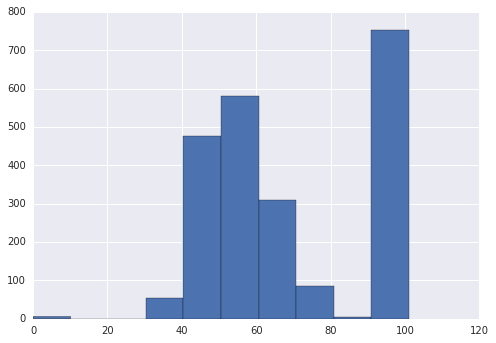

time: 232 ms


In [11]:
keys = ['wiki', 'googleart']
get_sim_matrix_and_plot(keys, force=False, n_jobs=16)

# keys = ['wga', 'artuk']
# get_sim_matrix_and_plot(keys)

In [12]:
check_pairs(['wiki', 'googleart'], 
            transpose=False,
            min_sim=85, max_sim=101, 
            discard_exaclty_matched_dates=False,
            min_k=1)

manually checked pairs: 77
count: 0
0


""


time: 478 ms


In [13]:
def check_sim_values(dataset_names, artist_ids):
    cur_dfs = [artists_with_years_dict[key] for key in dataset_names]
    indices = (0, 0)
    for i in xrange(2):
        idx = np.nonzero(cur_dfs[i]['artist_id'] == artist_ids[i])[0][0]
        print cur_dfs[i].iloc[idx]
        print '---'
    print indices
    sim = get_sim_matrix(dataset_names, force=False)
    print 'sim=', sim[indices[0], indices[1]]

check_sim_values(['wiki', 'googleart'], ['wiki_johan-hendrik-weissenbruch', 'googleart_m026t8y5'])

artist_name                           johan hendrik weissenbruch
years          [nan, nan, nan, nan, nan, nan, nan, 1893.0, 18...
artist_id                        wiki_johan-hendrik-weissenbruch
artist_ids                     [wiki_johan-hendrik-weissenbruch]
years_work                                      [1847.0, 1903.0]
works_count                                                   82
years_bio                                           [1824, 1903]
years_range                                         [1824, 1903]
names                               [johan hendrik weissenbruch]
url_wiki       https://en.wikipedia.org/wiki/Jan_Hendrik_Weis...
Name: wiki_johan-hendrik-weissenbruch, dtype: object
---
artist_id                                           googleart_m026t8y5
bio                  Hendrik Johannes Weissenbruch was a Dutch pain...
page_url             https://www.google.com/culturalinstitute/beta/...
total_items_count                                                   21
url_wiki 

In [14]:
dataset_names = ['wiki', 'googleart']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

merged_df = get_merged_artists_df(dataset_names, dfs_to_merge, sim)
artists_with_years_dict['wiki+googleart'] = merged_df

  2%|▏         | 51/2270 [00:00<00:04, 507.28it/s]

connected_components at the beginning: 6650


  2%|▏         | 95/5906 [00:00<00:06, 949.39it/s]

connected_components: 5906
big_components number: 0


100%|██████████| 5906/5906 [00:05<00:00, 1049.00it/s]

time: 10.6 s


wiki+googleart-wga
(5906, 4727)


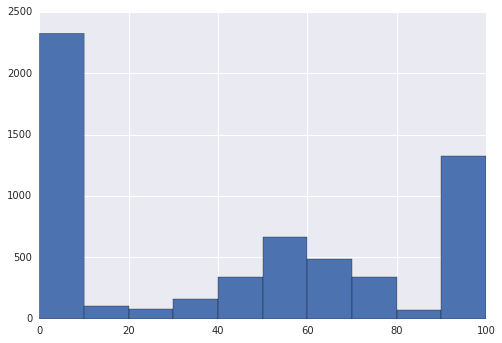

time: 301 ms


In [15]:
%autoreload
keys = ['wiki+googleart', 'wga']
get_sim_matrix_and_plot(keys, force=False, n_jobs=16)

In [16]:
%autoreload
dataset_names = ['wiki+googleart', 'wga']
results_df = check_pairs(dataset_names, 
                transpose=False,
                min_sim=85, max_sim=111, 
                discard_exaclty_matched_dates=True,
                min_k=2)

if len(results_df):
    results_df['year_diff'] = results_df.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)
results_df

# Transposed
results_df_transposed = check_pairs(dataset_names, 
                transpose=True,
                min_sim=85, max_sim=111, 
                discard_exaclty_matched_dates=False,
                min_k=2)
if len(results_df_transposed):
    results_df_transposed['year_diff'] = results_df_transposed.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)

if len(results_df):
    appended = results_df.append(results_df_transposed, ignore_index=True)
    appended = appended.drop_duplicates(['artist_id_wga', 'artist_id_wiki+googleart'])
    appended = appended[results_df.columns]
else:
    appended = results_df_transposed

# appended = results_df
output_path = '/export/home/asanakoy/workspace/dataset_merger/aggregated/{}_check_matches.csv'.format('-'.join(dataset_names))
appended.to_csv(output_path, encoding='utf-8')
print 'Total rows', len(appended)
appended

manually checked pairs: 365
count: 0
0
manually checked pairs: 365
count: 0
0
Total rows 0


""


time: 3.54 s


In [17]:
# artists_with_years_dict['googleart']['url_wiki'] = artists_with_years_dict['googleart']['url_wiki'].apply(lambda x: 'https://en.wikipedia.org/wiki/ernest_meissonier' if x == 'http://en.wikipedia.org/wiki/jean-louis-ernest_meissonier' else x)


# ids = list()
# for comp in big_comp_wiki_googleart:
#     comp = sorted(list(comp))
#     ids.extend(comp[:2])
# artists_with_years_dict['wiki+googleart'][['artist_name', 'years_range', 'url_wiki']].iloc[ids]

time: 2.14 ms


In [18]:
dataset_names = ['wiki+googleart', 'wga']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

merged_df = get_merged_artists_df(dataset_names, dfs_to_merge, sim)
artists_with_years_dict['+'.join(dataset_names)] = merged_df
merged_df.to_hdf('artists_{}.hdf5'.format('+'.join(dataset_names)), 'df', mode='w')
merged_df

  1%|          | 46/5906 [00:00<00:12, 453.35it/s]

connected_components at the beginning: 10633


  1%|          | 104/9377 [00:00<00:08, 1036.14it/s]

connected_components: 9377
big_components number: 0


100%|██████████| 9377/9377 [00:07<00:00, 1232.81it/s]


,artist_ids,artist_name,bio,names,page_url,url_wiki,works_count,years,years_bio,years_range,years_work,artist_id
artist_id,,,,,,,,,,,,
wiki_3d,[wiki_3d],3d,NaN,"[robert del naja, 3d]",NaN,https://en.wikipedia.org/wiki/Robert_Del_Naja,10,"[1984.0, 1986.0, 1988.0, 1991.0, 1994.0, 1983.0]","[1966, 2099]","[1966, 2099]","[1983.0, 1994.0]",wiki_3d
wiki_a-y-jackson,[wiki_a-y-jackson],a y jackson,NaN,"[a y jackson, alexander young jackson, a.y. ja...",NaN,https://en.wikipedia.org/wiki/A._Y._Jackson,30,"[1920.0, 1953.0, 1921.0, 1923.0, 1926.0, 1927....","[1882, 1974]","[1882, 1974]","[1910.0, 1953.0]",wiki_a-y-jackson
wiki_abanindranath-tagore,"[wiki_abanindranath-tagore, googleart_m0632pc]",abanindranath tagore,Abanindranath Tagore was the principal artist ...,[abanindranath tagore],[https://www.google.com/culturalinstitute/beta...,https://en.wikipedia.org/wiki/Abanindranath_Ta...,138,"[1920.0, 1924.0, 1927.0, 1929.0, 1930.0, 1906....","[1871, 1951]","[1871, 1951]","[1897.0, 1939.0]",wiki_abanindranath-tagore
wiki_abdul-qader-al-raes,[wiki_abdul-qader-al-raes],abdul qader al raes,NaN,[abdul qader al raes],NaN,https://en.wikipedia.org/wiki/Abdul_Qader_Al_Rais,17,"[2008.0, 2011.0, 1995.0, 1998.0, 2007.0]","[1951, 2099]","[1951, 2099]","[1995.0, 2011.0]",wiki_abdul-qader-al-raes
wiki_abdullah-suriosubroto,[wiki_abdullah-suriosubroto],abdullah suriosubroto,NaN,[abdullah suriosubroto],NaN,https://id.wikipedia.org/wiki/Abdullah_Suriosu...,18,NaN,"[1878, 1941]","[1878, 1941]",NaN,wiki_abdullah-suriosubroto
wiki_abidin-dino,[wiki_abidin-dino],abidin dino,NaN,[abidin dino],NaN,https://en.wikipedia.org/wiki/Abidin_Dino,54,"[1955.0, 1956.0, 1989.0, 1990.0, 1961.0, 1930....","[1913, 1993]","[1913, 1993]","[1930.0, 1993.0]",wiki_abidin-dino
wiki_abraham-manievich,[wiki_abraham-manievich],abraham manievich,NaN,"[abraham manievich, абрам маневич]",NaN,https://en.wikipedia.org/wiki/Abraham_A._Manie...,53,"[1921.0, 1923.0, 1925.0, 1905.0, 1929.0, 1930....","[1881, 1941]","[1881, 1941]","[1905.0, 1939.0]",wiki_abraham-manievich
wiki_abraham-palatnik,[wiki_abraham-palatnik],abraham palatnik,NaN,[abraham palatnik],NaN,https://en.wikipedia.org/wiki/Abraham_Palatnik,3,[1965.0],"[1928, 2099]","[1928, 2099]","[1965.0, 1965.0]",wiki_abraham-palatnik
wiki_abraham-van-strij,"[wiki_abraham-van-strij, wga_strij, abraham va...",abraham van strij,NaN,"[abraham van strij, strij, abraham van, i]",NaN,https://en.wikipedia.org/wiki/Abraham_van_Strij,45,"[1800.0, 1825.0, 1810.0]","[1753, 1826]","[1753, 1826]","[1800.0, 1825.0]",wiki_abraham-van-strij


time: 23.4 s


In [19]:
artists_with_years_dict.keys()

['wiki',
 'wga',
 'wiki+googleart+wga',
 'wiki+googleart',
 'googleart',
 'meisterwerke']

time: 3.38 ms


In [20]:
dataset_names = ['wiki', 'googleart', 'wga', 'wiki+googleart+wga']
for key in dataset_names:
    print '{}: {} unique artists'.format(key, len(artists_with_years_dict[key]))

wiki: 2270 unique artists
googleart: 4380 unique artists
wga: 4727 unique artists
wiki+googleart+wga: 9377 unique artists
time: 4.08 ms


wiki+googleart+wga-meisterwerke


  0%|          | 0/9377 [00:00<?, ?it/s]

Num taks: 9377


100%|██████████| 9377/9377 [05:22<00:00, 29.09it/s]
[Parallel(n_jobs=16)]: Done 9377 out of 9377 | elapsed:  5.4min finished


Sim matrix saved to sim_matrix_wiki+googleart+wga-meisterwerke.npy
(9377, 2165)


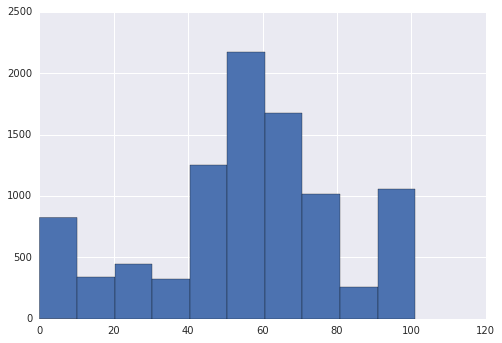

time: 5min 29s


In [21]:
##### MEISTERWERKE #######

%autoreload
keys = ['wiki+googleart+wga', 'meisterwerke']
get_sim_matrix_and_plot(keys, force=True, n_jobs=16)

In [22]:
##### MEISTERWERKE #######
%autoreload
dataset_names = ['wiki+googleart+wga', 'meisterwerke']
results_df = []
results_df = check_pairs(dataset_names, 
                transpose=False,
                min_sim=95, max_sim=101, 
                discard_exaclty_matched_dates=False,
                min_k=1,
                min_total_works_count=10)

if len(results_df):
    results_df['year_diff'] = results_df.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)
results_df

# Transposed
results_df_transposed = []
results_df_transposed = check_pairs(dataset_names, 
                transpose=True,
                min_sim=95, max_sim=101, 
                discard_exaclty_matched_dates=False,
                min_k=1,
                min_total_works_count=10)
if len(results_df_transposed):
    results_df_transposed['year_diff'] = results_df_transposed.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)

if len(results_df) and len(results_df_transposed):
    appended = results_df.append(results_df_transposed, ignore_index=True)
    appended = appended.drop_duplicates(['artist_id_' + key for key in dataset_names])
    appended = appended[results_df.columns]
#     assert len(appended['artist_id_meisterwerke'].unique()) == len(appended), len(appended['artist_id_meisterwerke'].unique())
    appended.sort_values(by='artist_id_wiki+googleart+wga', inplace=True)
elif len(results_df):
    appended = results_df
elif len(results_df_transposed):
    appended = results_df_transposed
else:
    appended = pd.DataFrame()
    
# appended.sort_values(by='artist_id_wiki+googleart+wga', inplace=True)
# appended.sort_values(by='artist_id_meisterwerke', inplace=True)



output_path = '/export/home/asanakoy/workspace/dataset_merger/aggregated/{}_check_matches.csv'.format('-'.join(dataset_names))
appended.to_csv(output_path, encoding='utf-8')
print 'Total rows', len(appended)
print dataset_names
appended

manually checked pairs: 924
count: 0
0
manually checked pairs: 924
count: 0
0
Total rows 0
['wiki+googleart+wga', 'meisterwerke']


""


time: 41.7 s


In [23]:
##### MEISTERWERKE #######
dataset_names = ['wiki+googleart+wga', 'meisterwerke']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

# artists_with_years_dict['+'.join(dataset_names)] = get_merged_artists_df(dataset_names, dfs_to_merge, sim)


assert len(dataset_names) == len(dfs_to_merge)
assert sim.shape == (len(dfs_to_merge[0]), len(dfs_to_merge[1])), sim.shape


manually_checked_matches_path = 'manually_corrected_matches/{}_manually_corrected_matches.csv'.format(
    '-'.join(dataset_names))
if os.path.exists(manually_checked_matches_path):
    manually_checked_matches_df = pd.read_csv(manually_checked_matches_path, index_col=0,
                                              encoding='utf-8')
    sim = fix_sim_matrix(dataset_names,
                                dfs_to_merge,
                                sim,
                                manually_checked_matches_df)

connected_components = find_connected_components(sim, min_sim=100)
big_comp = [x for x in connected_components if len(x) > 2]
small_comp = [x for x in connected_components if len(x) <= 2]
# connected_components = small_comp + [{el} for x in big_comp for el in x]
# big_comp = [x for x in connected_components if len(x) > 2]

print 'num big_comp', len(big_comp)
# assert len(big_comp) == 0, len(big_comp)
big_comp

  1%|          | 93/9377 [00:00<00:10, 924.40it/s]

connected_components at the beginning: 11542


100%|██████████| 9377/9377 [00:10<00:00, 869.79it/s]


connected_components: 10508
num big_comp 62


[{298, 1000293, 1000295},
 {617, 1001069, 1001070},
 {775, 1002025, 1002026},
 {777, 1000660, 1000661},
 {852, 1000727, 1000915},
 {1794, 1000377, 1000378},
 {1804, 1001517, 1001614},
 {1838, 1001696, 1001697, 1001698},
 {1914, 1002119, 1002120},
 {1985, 1000367, 1001853},
 {2189, 1002080, 1002095},
 {2913, 1000732, 1001926},
 {2215, 2922, 1000787},
 {3067, 1002068, 1002069, 1002070},
 {3079, 1000746, 1000747, 1000748},
 {3324, 1001056, 1002145},
 {3602, 1000665, 1001181},
 {3847, 1000812, 1002076},
 {4019, 1000592, 1000658},
 {4171, 1001560, 1001561},
 {4621, 1001177, 1001178},
 {3924, 5979, 1000087},
 {3097, 5993, 1000098},
 {6033, 1000119, 1000120},
 {1677, 6057, 1000137},
 {2860, 6090, 1000150},
 {6193, 6194, 1000215},
 {113, 6324, 1000296},
 {2568, 6337, 1000301},
 {6485, 6486, 1000408},
 {2366, 6675, 1000526},
 {6738, 6739, 1000582},
 {3027, 6767, 1000597},
 {1435, 6907, 1000680},
 {4532, 7005, 1000631},
 {654, 7022, 1000724},
 {3078, 7040, 1000744},
 {7056, 1000759, 1000760},
 {

time: 12.3 s


In [24]:
# TODO: filter out big components. Recheck them
# TODO: merge images wga wiki. googleart
# these are mostly followers of the artists in the meisterwerke and workshops.
# But they have to be manually checked
big_comp

[{298, 1000293, 1000295},
 {617, 1001069, 1001070},
 {775, 1002025, 1002026},
 {777, 1000660, 1000661},
 {852, 1000727, 1000915},
 {1794, 1000377, 1000378},
 {1804, 1001517, 1001614},
 {1838, 1001696, 1001697, 1001698},
 {1914, 1002119, 1002120},
 {1985, 1000367, 1001853},
 {2189, 1002080, 1002095},
 {2913, 1000732, 1001926},
 {2215, 2922, 1000787},
 {3067, 1002068, 1002069, 1002070},
 {3079, 1000746, 1000747, 1000748},
 {3324, 1001056, 1002145},
 {3602, 1000665, 1001181},
 {3847, 1000812, 1002076},
 {4019, 1000592, 1000658},
 {4171, 1001560, 1001561},
 {4621, 1001177, 1001178},
 {3924, 5979, 1000087},
 {3097, 5993, 1000098},
 {6033, 1000119, 1000120},
 {1677, 6057, 1000137},
 {2860, 6090, 1000150},
 {6193, 6194, 1000215},
 {113, 6324, 1000296},
 {2568, 6337, 1000301},
 {6485, 6486, 1000408},
 {2366, 6675, 1000526},
 {6738, 6739, 1000582},
 {3027, 6767, 1000597},
 {1435, 6907, 1000680},
 {4532, 7005, 1000631},
 {654, 7022, 1000724},
 {3078, 7040, 1000744},
 {7056, 1000759, 1000760},
 {

time: 10.8 ms


In [25]:
%autoreload
dataset_names = ['wiki+googleart+wga', 'meisterwerke']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

merged_df = get_merged_artists_df(dataset_names, dfs_to_merge, sim, 
                                  split_big_components=False, 
                                  allow_big_components=True)
artists_with_years_dict['+'.join(dataset_names)] = merged_df
print 'Num unique artists:', len(merged_df)
merged_df.to_hdf('info/artists_{}_v0.92.hdf5'.format('+'.join(dataset_names)), 'df', mode='w')
# merged_df.to_csv('artists_{}_alpha.csv'.format('+'.join(dataset_names)), encoding='utf-8')
merged_df

  1%|          | 93/9377 [00:00<00:10, 927.96it/s]

connected_components at the beginning: 11542


  1%|          | 101/10508 [00:00<00:10, 999.38it/s]

connected_components: 10508
big_components number: 62


100%|██████████| 10508/10508 [00:08<00:00, 1240.88it/s]


,artist_ids,artist_name,bio,names,page_url,url_wiki,works_count,years,years_bio,years_range,years_work,artist_id
artist_id,,,,,,,,,,,,
wiki_3d,[wiki_3d],3d,NaN,"[robert del naja, 3d]",NaN,https://en.wikipedia.org/wiki/Robert_Del_Naja,10,"[1984.0, 1986.0, 1988.0, 1991.0, 1994.0, 1983.0]","[1966, 2099]","[1966, 2099]","[1983.0, 1994.0]",wiki_3d
wiki_a-y-jackson,[wiki_a-y-jackson],a y jackson,NaN,"[a y jackson, alexander young jackson, a.y. ja...",NaN,https://en.wikipedia.org/wiki/A._Y._Jackson,30,"[1920.0, 1953.0, 1921.0, 1923.0, 1926.0, 1927....","[1882, 1974]","[1882, 1974]","[1910.0, 1953.0]",wiki_a-y-jackson
wiki_abanindranath-tagore,"[wiki_abanindranath-tagore, googleart_m0632pc]",abanindranath tagore,Abanindranath Tagore was the principal artist ...,[abanindranath tagore],[https://www.google.com/culturalinstitute/beta...,https://en.wikipedia.org/wiki/Abanindranath_Ta...,138,"[1920.0, 1924.0, 1927.0, 1929.0, 1930.0, 1938....","[1871, 1951]","[1871, 1951]","[1897.0, 1939.0]",wiki_abanindranath-tagore
wiki_abdul-qader-al-raes,[wiki_abdul-qader-al-raes],abdul qader al raes,NaN,[abdul qader al raes],NaN,https://en.wikipedia.org/wiki/Abdul_Qader_Al_Rais,17,"[2008.0, 2011.0, 1998.0, 1995.0, 2007.0]","[1951, 2099]","[1951, 2099]","[1995.0, 2011.0]",wiki_abdul-qader-al-raes
wiki_abdullah-suriosubroto,[wiki_abdullah-suriosubroto],abdullah suriosubroto,NaN,[abdullah suriosubroto],NaN,https://id.wikipedia.org/wiki/Abdullah_Suriosu...,18,NaN,"[1878, 1941]","[1878, 1941]",NaN,wiki_abdullah-suriosubroto
wiki_abidin-dino,[wiki_abidin-dino],abidin dino,NaN,[abidin dino],NaN,https://en.wikipedia.org/wiki/Abidin_Dino,54,"[1955.0, 1956.0, 1989.0, 1990.0, 1961.0, 1930....","[1913, 1993]","[1913, 1993]","[1930.0, 1993.0]",wiki_abidin-dino
wiki_abraham-manievich,[wiki_abraham-manievich],abraham manievich,NaN,"[abraham manievich, абрам маневич]",NaN,https://en.wikipedia.org/wiki/Abraham_A._Manie...,53,"[1921.0, 1923.0, 1925.0, 1937.0, 1929.0, 1930....","[1881, 1941]","[1881, 1941]","[1905.0, 1939.0]",wiki_abraham-manievich
wiki_abraham-palatnik,[wiki_abraham-palatnik],abraham palatnik,NaN,[abraham palatnik],NaN,https://en.wikipedia.org/wiki/Abraham_Palatnik,3,[1965.0],"[1928, 2099]","[1928, 2099]","[1965.0, 1965.0]",wiki_abraham-palatnik
wiki_abraham-van-strij,"[wiki_abraham-van-strij, wga_strij, abraham va...",abraham van strij,NaN,"[abraham van strij, strij, abraham van, i]",NaN,https://en.wikipedia.org/wiki/Abraham_van_Strij,45,"[1800.0, 1825.0, 1810.0]","[1753, 1826]","[1753, 1826]","[1800.0, 1825.0]",wiki_abraham-van-strij


time: 21.8 s


In [26]:
artists_with_years_dict['meisterwerke'].iloc[[ 1538, 1539]]
# artists_with_years_dict['meisterwerke'][artists_with_years_dict['meisterwerke'].index == 'meisterwerke_unknown']

,artist_name,years,artist_id,artist_ids,years_work,works_count,years_bio,years_range,names,url_wiki
"meisterwerke_orcagna, andrea","orcagna, andrea",[1350.0],"meisterwerke_orcagna, andrea","[meisterwerke_orcagna, andrea]","[1350.0, 1350.0]",1,NaN,"[1350.0, 1350.0]","[orcagna, andrea]",NaN
"meisterwerke_orcagna, andrea (nachfolger)","orcagna, andrea (nachfolger)",[1371.0],"meisterwerke_orcagna, andrea (nachfolger)","[meisterwerke_orcagna, andrea (nachfolger)]","[1371.0, 1371.0]",1,NaN,"[1371.0, 1371.0]","[orcagna, andrea (nachfolger)]",NaN


time: 23.2 ms


In [27]:
# artists_with_years_dict['meisterwerke'] = get_artists_with_years('meisterwerke', dfs)

time: 1.09 ms
